In [1]:
from pyspark.sql import SparkSession 

spark = SparkSession.builder \
    .appName("NLP Pipeline") \
    .config("spark.python.worker.reuse", "true") \
    .config("spark.executor.heartbeatInterval", "120s") \
    .config("spark.network.timeout", "300s") \
    .getOrCreate()


path=r"C:\Users\aamir\Desktop\YC\P\spam-detection-nlp\data\raw\DataSet_Emails.csv"
df = spark.read.csv(path,header=True,inferSchema=True , multiLine=True , escape='"')

In [2]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



In [3]:
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|summary|              _c0|        message_id|                text|             label|label_text|             subject|             message|
+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|  count|            31716|             31716|               31665|             31716|     31716|               31442|               31371|
|   mean|          15857.5|16854.187539412284|                NULL|0.5096165973010468|      NULL|            386429.0|            71403.25|
| stddev|9155.764905238666| 9734.616391716854|                NULL|0.4999153936875302|      NULL|  481877.22667086066|   136659.2035841348|
|    min|                0|                 0| ( b  $ b ! zck...|                 0|       ham|                ( b| & who wants to ...|
|    max|           

In [4]:
df.show(5)

+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|    0|       ham|enron / hpl actua...|teco tap 30 . 000...|2000-12-12|
|  4|     15880|looking for cheap...|    1|      spam|looking for cheap...|water past also ,...|2005-02-13|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
only showing top 5 rows


In [5]:
df = df.select('label' , 'text')


In [6]:
df = df.dropDuplicates()


In [7]:
from pyspark.sql.functions import col, sum

missing_data = df.filter(" OR ".join([f"{c} IS NULL" for c in df.columns]))
null_counts = missing_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in missing_data.columns])
null_counts.show()


+-----+----+
|label|text|
+-----+----+
|    0|   1|
+-----+----+



In [8]:
df_clean = df.dropna()

In [9]:
df_clean.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|13829|
|    0|14982|
+-----+-----+



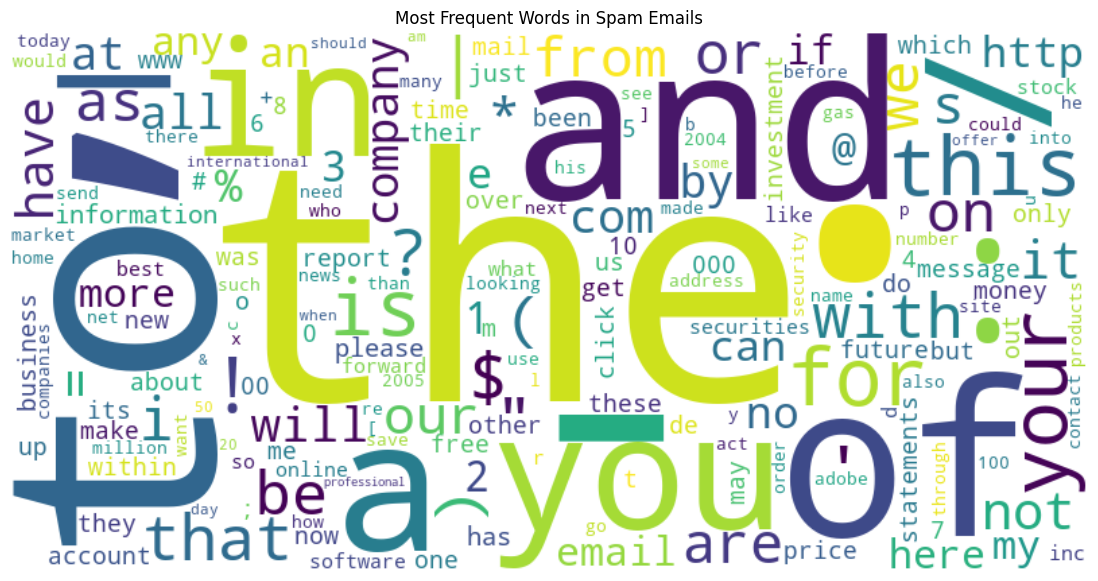

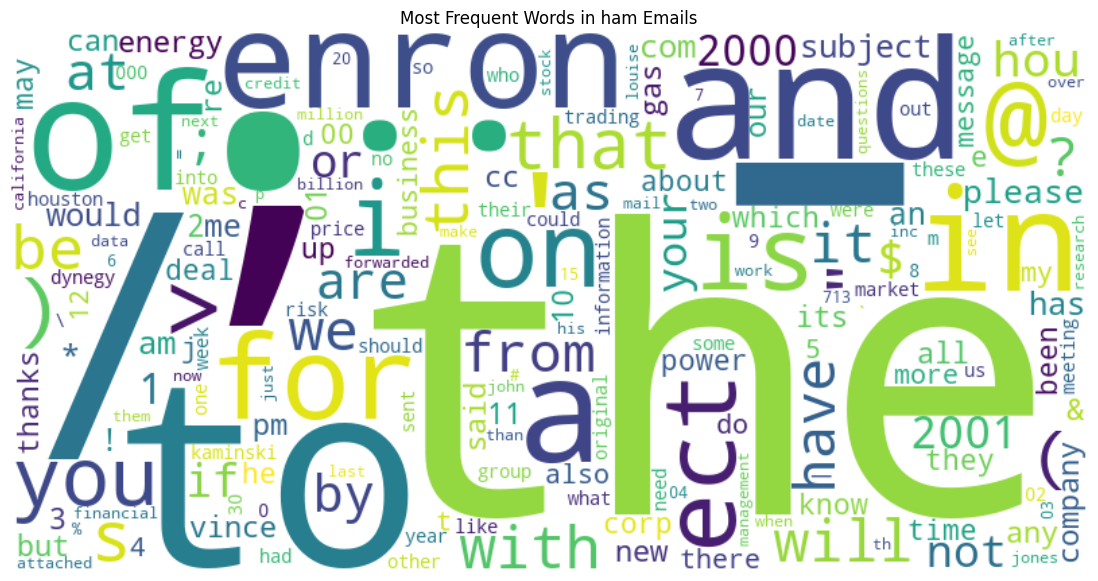

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode, split, lower

spam_df = df_clean.filter(col('label') == 1)
ham_df = df_clean.filter(col('label') == 0)

def create_wordcloud(title , df):
    words_df = df.select(explode(split(lower(col('text')), r'\s+')).alias('word'))
    
    word_freq = words_df.groupBy('word').count()

    top_words = word_freq.orderBy(col('count').desc()).limit(1000).collect()

    freq_dict = {row['word']: row['count'] for row in top_words}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud("Most Frequent Words in Spam Emails" , spam_df)
create_wordcloud("Most Frequent Words in ham Emails" , ham_df)



In [11]:
df_lower = (
    df_clean.withColumn("text", lower(col("text")))
)
df_lower.show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    0|fw : final revise...|
|    1|unregistered inst...|
|    1|mlcrosoft clearan...|
|    1|commercial servic...|
|    1|thats how p / orn...|
|    0|re : " project do...|
|    1|pain charset = is...|
|    1|do you ejakulate ...|
|    1|re : milan waterp...|
|    1|entrust your visu...|
|    0|clean fuels - gpg...|
|    0|re : tw capacity ...|
|    0|re : industrials ...|
|    0|urgent ed has req...|
|    0|january - meter 2...|
|    0|start date : 1 / ...|
|    1|your account will...|
|    1|tupelo notificati...|
|    1|tetm : 22 , inter...|
|    1|want a cablefilte...|
+-----+--------------------+
only showing top 20 rows


In [12]:
from pyspark.ml.feature import RegexTokenizer

regex_tokenizer = RegexTokenizer(
    inputCol="text",
    outputCol="tokens",
    pattern="\\W+"    
)

In [13]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="tokens_no_sw"
)

In [14]:
from StemmerTransformer import StemmerTransformer

stemmer_transform = StemmerTransformer(inputCol="tokens_no_sw", outputCol="stemmed_tokens")


In [15]:
from pyspark.ml.feature import HashingTF , IDF

hashingTF = HashingTF(
    inputCol="stemmed_tokens",
    outputCol="raw_features",
    numFeatures=20000
)

idf = IDF(
    inputCol="raw_features",
    outputCol="features"
)



In [16]:
train_df, test_df = df_lower.randomSplit([0.8, 0.2], seed=42)

In [17]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

preproc_stages = [regex_tokenizer, remover, stemmer_transform, hashingTF, idf]

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

In [18]:
from pyspark.ml import Pipeline


pipeline_lr = Pipeline(stages=preproc_stages + [lr])
pipeline_rf = Pipeline(stages=preproc_stages +[rf])

In [19]:
import os

os.environ["PYSPARK_PYTHON"] = r"C:\Users\aamir\AppData\Local\Programs\Python\Python310\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\aamir\AppData\Local\Programs\Python\Python310\python.exe"


In [20]:
model_lr = pipeline_lr.fit(train_df)
model_rf = pipeline_rf.fit(train_df)


Py4JJavaError: An error occurred while calling o157.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 35.0 failed 1 times, most recent failure: Lost task 15.0 in stage 35.0 (TID 87) (DESKTOP-1533774 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:161)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 48 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2579)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1211)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1205)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1297)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1250)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1250)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:55)
	at org.apache.spark.ml.feature.IDF.fit(IDF.scala:93)
	at org.apache.spark.ml.feature.IDF.fit(IDF.scala:69)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:161)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:107)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 48 more


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

def evaluate_model(model, test_df):
    preds = model.transform(test_df)
    acc = evaluator_acc.evaluate(preds)
    f1  = evaluator_f1.evaluate(preds)
    return acc, f1

acc_lr, f1_lr = evaluate_model(model_lr, test_df)
acc_rf, f1_rf = evaluate_model(model_rf, test_df)

print("LogisticReg  -> acc: {:.4f} | f1: {:.4f}".format(acc_lr, f1_lr))
print("RandomForest -> acc: {:.4f} | f1: {:.4f}".format(acc_rf, f1_rf))


25/11/27 00:51:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 00:51:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 00:52:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 00:52:12 WARN CSVHeaderChecker: CSV header does not confor

LogisticReg  -> acc: 0.9793 | f1: 0.9793
RandomForest -> acc: 0.9451 | f1: 0.9451


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


lr = pipeline_lr.getStages()[-1]

paramGrid_lr = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 0.3])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.maxIter, [20, 50])
    .build()
)

cv_lr = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_f1,
    numFolds=3,            
    parallelism=4          
)

cv_model_lr = cv_lr.fit(train_df)


25/11/27 00:52:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 00:53:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 00:57:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 00:58:39 WARN CSVHeaderChecker: CSV header does not confor

In [ ]:
rf = pipeline_rf.getStages()[-1]

paramGrid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 7])
    .build()
)

cv_rf = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_f1,
    numFolds=3,
    parallelism=4
)

cv_model_rf = cv_rf.fit(train_df)


25/11/27 01:08:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 01:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1266.6 KiB
25/11/27 01:10:00 WARN MemoryStore: Not enough space to cache rdd_12045_1 in memory! (computed 48.4 MiB so far)
25/11/27 01:10:00 WARN MemoryStore: Not enough space to cache rdd_12045_3 in memory! (computed 32.2 MiB so far)
25/11/27 01:10:00 WARN MemoryStore: Not enough space to cache rdd_12045_5 in memory! (computed 20.9 MiB so far)
25/11/27 01:10:00 WARN MemoryStore: Not enough space to cache rdd_12045_4 in memory! (computed 32.2 MiB so far)
25/11/27 01:10:00 WARN MemoryStore: Not enough space to cache rdd_12045_7 in memory! (computed 20.9 MiB so far)
25/11/27 01:10:00 WARN BlockManager: Per

In [ ]:
acc_lr, f1_lr = evaluate_model(cv_model_lr, test_df)
acc_rf, f1_rf = evaluate_model(cv_model_rf, test_df)

print("LogisticReg (CV)  -> acc: {:.4f} | f1: {:.4f}".format(acc_lr, f1_lr))
print("RandomForest (CV) -> acc: {:.4f} | f1: {:.4f}".format(acc_rf, f1_rf))


25/11/27 01:16:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 01:16:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 01:16:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///app/DataSet_Emails/DataSet_Emails.csv
25/11/27 01:16:43 WARN CSVHeaderChecker: CSV header does not confor

LogisticReg (CV)  -> acc: 0.9808 | f1: 0.9808
RandomForest (CV) -> acc: 0.9451 | f1: 0.9451


In [ ]:
print("Best Logistic Regression Params:")
best_lr = cv_model_lr.bestModel.stages[-1]
print(best_lr._java_obj.parent().extractParamMap())


Best Logistic Regression Params:
{
	LogisticRegression_34cae3a6c089-aggregationDepth: 2,
	LogisticRegression_34cae3a6c089-elasticNetParam: 0.0,
	LogisticRegression_34cae3a6c089-family: auto,
	LogisticRegression_34cae3a6c089-featuresCol: features,
	LogisticRegression_34cae3a6c089-fitIntercept: true,
	LogisticRegression_34cae3a6c089-labelCol: label,
	LogisticRegression_34cae3a6c089-maxBlockSizeInMB: 0.0,
	LogisticRegression_34cae3a6c089-maxIter: 50,
	LogisticRegression_34cae3a6c089-predictionCol: prediction,
	LogisticRegression_34cae3a6c089-probabilityCol: probability,
	LogisticRegression_34cae3a6c089-rawPredictionCol: rawPrediction,
	LogisticRegression_34cae3a6c089-regParam: 0.01,
	LogisticRegression_34cae3a6c089-standardization: true,
	LogisticRegression_34cae3a6c089-threshold: 0.5,
	LogisticRegression_34cae3a6c089-tol: 1.0E-6
}


In [ ]:
print("Best Random Forest Params:")
best_rf = cv_model_rf.bestModel.stages[-1]
print(best_rf._java_obj.parent().extractParamMap())


Best Random Forest Params:
{
	RandomForestClassifier_925881649b48-bootstrap: true,
	RandomForestClassifier_925881649b48-cacheNodeIds: false,
	RandomForestClassifier_925881649b48-checkpointInterval: 10,
	RandomForestClassifier_925881649b48-featureSubsetStrategy: auto,
	RandomForestClassifier_925881649b48-featuresCol: features,
	RandomForestClassifier_925881649b48-impurity: gini,
	RandomForestClassifier_925881649b48-labelCol: label,
	RandomForestClassifier_925881649b48-leafCol: ,
	RandomForestClassifier_925881649b48-maxBins: 32,
	RandomForestClassifier_925881649b48-maxDepth: 5,
	RandomForestClassifier_925881649b48-maxMemoryInMB: 256,
	RandomForestClassifier_925881649b48-minInfoGain: 0.0,
	RandomForestClassifier_925881649b48-minInstancesPerNode: 1,
	RandomForestClassifier_925881649b48-minWeightFractionPerNode: 0.0,
	RandomForestClassifier_925881649b48-numTrees: 100,
	RandomForestClassifier_925881649b48-predictionCol: prediction,
	RandomForestClassifier_925881649b48-probabilityCol: probabi

In [ ]:
best_model = cv_model_lr.bestModel
best_model.write().overwrite().save("models/best_lr_pipeline")
